# Image classifier

In [3]:
!pip install torch
!pip install torchvision

In [81]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report,accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV,cross_validate,train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB,CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier, StackingClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage.filters import sobel,laplace,prewitt

## Dataset

In [2]:
transformer = transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])

In [3]:
train_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=True, download=True,
                             transform=transformer)

test_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=False, download=True,
                             transform=transformer)

batch_size_train= len(train_set)//5
batch_size_test=len(test_set)

In [4]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

In [5]:
train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

In [6]:
train_x.shape

torch.Size([12000, 1, 28, 28])

In [7]:
train_x[1].shape

torch.Size([1, 28, 28])

In [8]:
classes = [ 'T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
'Ankle boot']

In [9]:
def print_white_black_image(images,ys):
    num_row = 3
    num_col = 5
    
    images = [img[0, :, :] for img in images]
    labels = [classes[label] for label in ys]

    # plot images
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i], cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()

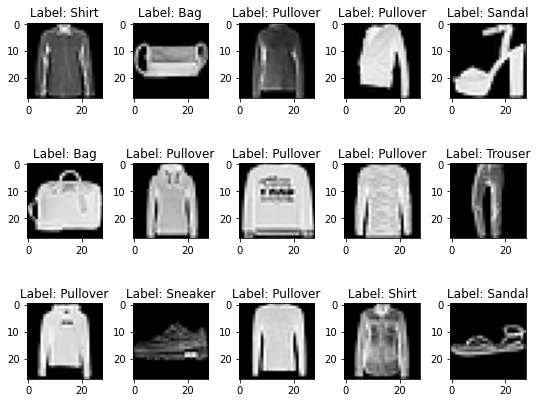

In [10]:
print_white_black_image(train_x[:15],train_y[:15])

## Preprocessing

We will use edge detecting filters.

In [11]:
def apply_filter(images,curr_filter):
    return [curr_filter(img) for img in images]

#### Sobel

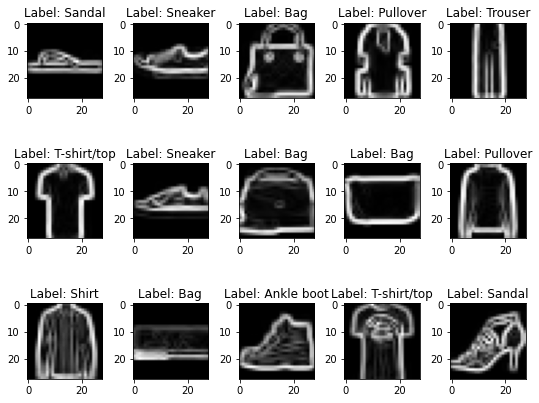

In [30]:
sobel_im = apply_filter(train_x[:15],sobel)
print_white_black_image(sobel_im,train_y[:15])

#### Laplace

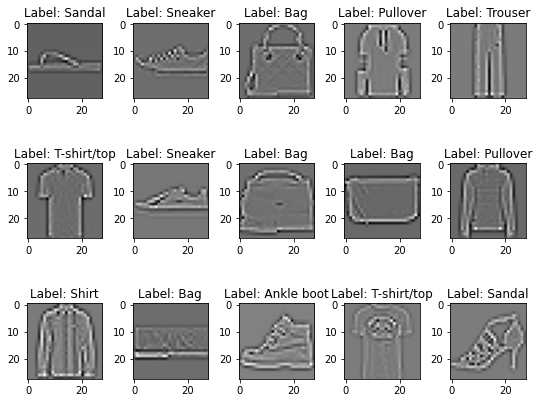

In [31]:
laplace_im = apply_filter(train_x[:15],laplace)
print_white_black_image(laplace_im,train_y[:15])

#### Prewitt

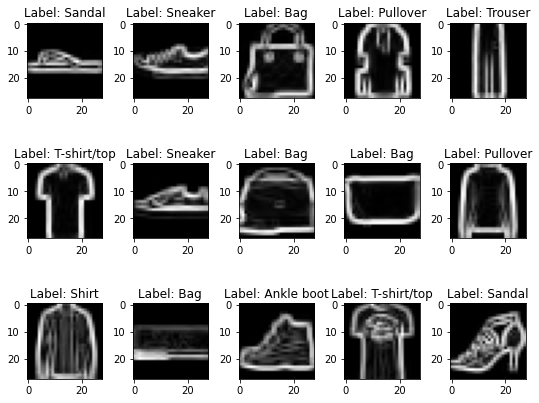

In [32]:
prewitt_im = apply_filter(train_x[:15],prewitt)
print_white_black_image(prewitt_im,train_y[:15])

The results from Sobel and Prewitt are really close and good whereas the images with Laplace filter are really blurry. We will use the sobel filter.

In [16]:
train_x = apply_filter(train_x,sobel) 
train_x = [torch.flatten(torch.Tensor(img)).numpy() for img in train_x]
test_x = apply_filter(test_x,sobel) 
test_x = [torch.flatten(torch.Tensor(img)).numpy() for img in test_x]

In [17]:
train_x[1].shape

(784,)

## Models
### Testing the models on the preprocessed dataset

In [51]:
bnb = BernoulliNB(alpha=0, binarize=0.05)
lr= LogisticRegression(n_jobs=-1)

bnb.fit(train_x,train_y)
lr.fit(train_x,train_y)

LogisticRegression(n_jobs=-1)

In [52]:
bnb_pred = bnb.predict(test_x)
lr_pred = lr.predict(test_x)

In [53]:
print (f'BernoulliNB F1 score = {f1_score(test_y, bnb_pred,average="micro")*100}')
print (f'LogisticRegression F1 score = {f1_score(test_y, lr_pred,average="micro")*100}')

print (f'BernoulliNB Classification Report \n {classification_report(test_y, bnb_pred, labels=range(0,10))}')
print (f'LogisticRegression Classification Report \n {classification_report(test_y, lr_pred, labels=range(0,10))}')

BernoulliNB F1 score = 65.48
LogisticRegression F1 score = 82.5
BernoulliNB Classification Report 
               precision    recall  f1-score   support

           0       0.73      0.79      0.75      1000
           1       0.85      0.89      0.87      1000
           2       0.56      0.63      0.59      1000
           3       0.65      0.73      0.69      1000
           4       0.47      0.60      0.53      1000
           5       0.74      0.18      0.30      1000
           6       0.38      0.15      0.22      1000
           7       0.60      0.89      0.72      1000
           8       0.83      0.80      0.81      1000
           9       0.71      0.88      0.78      1000

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.63     10000
weighted avg       0.65      0.65      0.63     10000

LogisticRegression Classification Report 
               precision    recall  f1-score   support

           0       0.78      0.81      0.79

In [55]:
gr_boost = GradientBoostingClassifier(n_estimators=20)

In [56]:
gr_boost.fit(train_x,train_y)
gr_pred = gr_boost.predict(test_x)

In [57]:
print (f'Gradient Boosting Classification Report \n {classification_report(test_y, gr_pred, labels=range(0,10))}')

Gradient Boosting Classification Report 
               precision    recall  f1-score   support

           0       0.78      0.75      0.76      1000
           1       0.97      0.91      0.94      1000
           2       0.69      0.76      0.72      1000
           3       0.73      0.83      0.78      1000
           4       0.69      0.70      0.70      1000
           5       0.93      0.87      0.90      1000
           6       0.59      0.51      0.55      1000
           7       0.87      0.91      0.89      1000
           8       0.92      0.89      0.91      1000
           9       0.90      0.92      0.91      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [58]:
print (f'Gradient Boosting F1 score = {f1_score(test_y, gr_pred,average="micro")*100}')

Gradient Boosting F1 score = 80.60000000000001


As we can see the edge detection filters do not improve the performance of our models. That is why we will not use them for future experiments.

### Dimension reduction
#### PCA

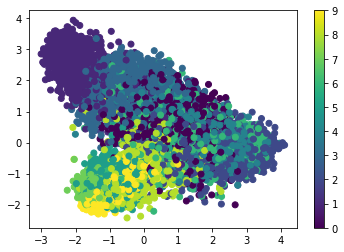

In [40]:
pca = PCA(n_components=50)
pca.fit(train_x)
pca_train_x = pca.transform(train_x)
pca_test_x = pca.transform(test_x)

# plot the PCA results
plt.scatter(pca_train_x[:, 0], pca_train_x[:, 1], c=train_y)
plt.colorbar()
plt.show()

In [41]:
bnb = BernoulliNB(alpha=0, binarize=0.05)
lr= LogisticRegression(n_jobs=-1)

bnb.fit(pca_train_x,train_y)
lr.fit(pca_train_x,train_y)

LogisticRegression(n_jobs=-1)

In [42]:
bnb_pred = bnb.predict(pca_test_x)
lr_pred = lr.predict(pca_test_x)

In [43]:
print (f'BernoulliNB F1 score = {f1_score(test_y, bnb_pred,average="micro")*100}')
print (f'LogisticRegression F1 score = {f1_score(test_y, lr_pred,average="micro")*100}')

print (f'BernoulliNB Classification Report \n {classification_report(test_y, bnb_pred, labels=range(0,10))}')
print (f'LogisticRegression Classification Report \n {classification_report(test_y, lr_pred, labels=range(0,10))}')

BernoulliNB F1 score = 69.73
LogisticRegression F1 score = 81.26
BernoulliNB Classification Report 
               precision    recall  f1-score   support

           0       0.73      0.69      0.71      1000
           1       0.87      0.83      0.85      1000
           2       0.57      0.60      0.58      1000
           3       0.66      0.73      0.69      1000
           4       0.55      0.60      0.57      1000
           5       0.75      0.77      0.76      1000
           6       0.48      0.48      0.48      1000
           7       0.82      0.77      0.79      1000
           8       0.80      0.70      0.74      1000
           9       0.82      0.81      0.81      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000

LogisticRegression Classification Report 
               precision    recall  f1-score   support

           0       0.78      0.77      0.7

In [47]:
def find_best_pca_param(comp_number):
    pca = PCA(n_components=comp_number)
    pca.fit(train_x)
    pca_train_x = pca.transform(train_x)
    pca_test_x = pca.transform(test_x)

    bnb = BernoulliNB(alpha=0, binarize=0.05)
    lr= LogisticRegression(n_jobs=-1)

    bnb.fit(pca_train_x,train_y)
    lr.fit(pca_train_x,train_y)
    
    return (bnb.score(pca_test_x,test_y)+lr.score(pca_test_x,test_y))/2

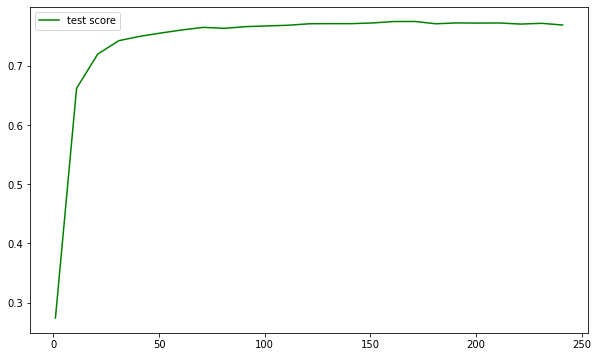

In [49]:
scores=[]
    
for k in range(1,250,10):
    scores.append(find_best_pca_param(k))


plt.figure(figsize=(10, 6))
plt.plot(range(1,250,10), scores, color='green', label='test score')
plt.legend()

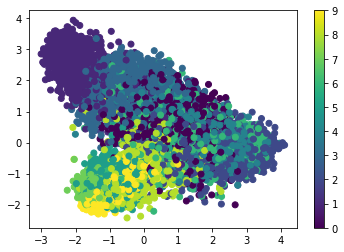

In [52]:
pca = PCA(n_components=180)
pca.fit(train_x)
pca_train_x = pca.transform(train_x)
pca_test_x = pca.transform(test_x)

# plot the PCA results
plt.scatter(pca_train_x[:, 0], pca_train_x[:, 1], c=train_y)
plt.colorbar()
plt.show()

In [53]:
bnb = BernoulliNB(alpha=0, binarize=0.05)
lr= LogisticRegression(n_jobs=-1)

bnb.fit(pca_train_x,train_y)
lr.fit(pca_train_x,train_y)

LogisticRegression(n_jobs=-1)

In [54]:
bnb_pred = bnb.predict(pca_test_x)
lr_pred = lr.predict(pca_test_x)

In [55]:
print (f'BernoulliNB F1 score = {f1_score(test_y, bnb_pred,average="micro")*100}')
print (f'LogisticRegression F1 score = {f1_score(test_y, lr_pred,average="micro")*100}')

print (f'BernoulliNB Classification Report \n {classification_report(test_y, bnb_pred, labels=range(0,10))}')
print (f'LogisticRegression Classification Report \n {classification_report(test_y, lr_pred, labels=range(0,10))}')

BernoulliNB F1 score = 71.69999999999999
LogisticRegression F1 score = 82.98999999999998
BernoulliNB Classification Report 
               precision    recall  f1-score   support

           0       0.74      0.69      0.72      1000
           1       0.89      0.84      0.87      1000
           2       0.62      0.61      0.61      1000
           3       0.67      0.74      0.70      1000
           4       0.59      0.58      0.59      1000
           5       0.79      0.80      0.79      1000
           6       0.51      0.48      0.50      1000
           7       0.84      0.79      0.81      1000
           8       0.71      0.80      0.75      1000
           9       0.82      0.83      0.83      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

LogisticRegression Classification Report 
               precision    recall  f1-score   support

           0      

This PCA improves our results.

In [57]:
gr_boost = GradientBoostingClassifier(n_estimators=20)
gr_boost.fit(pca_train_x,train_y)
gr_pred = gr_boost.predict(pca_test_x)
print (f'Gradient Boosting Classification Report \n {classification_report(test_y, gr_pred, labels=range(0,10))}')

Gradient Boosting Classification Report 
               precision    recall  f1-score   support

           0       0.73      0.77      0.75      1000
           1       0.98      0.91      0.94      1000
           2       0.68      0.61      0.64      1000
           3       0.76      0.82      0.79      1000
           4       0.67      0.69      0.68      1000
           5       0.81      0.85      0.83      1000
           6       0.51      0.51      0.51      1000
           7       0.84      0.84      0.84      1000
           8       0.87      0.83      0.85      1000
           9       0.89      0.89      0.89      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



In [58]:
print (f'Gradient Boosting F1 score = {f1_score(test_y, gr_pred,average="micro")*100}')

Gradient Boosting F1 score = 77.07


The score of the Gradient Boosting is lower. However, our goal is to increase the score of the base algorithms. That is why we will continue with the experiments.

#### T-distributed Stochastic Neighbor Embedding 

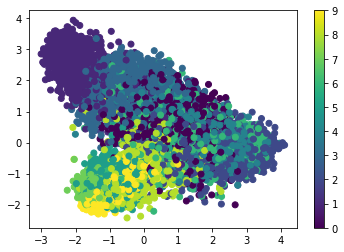

In [60]:
tsne = TSNE()
tsne.fit(train_x)
tsne_train_x = tsne.transform(train_x)
tsne_test_x = tsne.transform(test_x)

# plot the PCA results
plt.scatter(tsne_train_x[:, 0], tsne_train_x[:, 1], c=train_y)
plt.colorbar()
plt.show()

In [61]:
bnb = BernoulliNB(alpha=0, binarize=0.05)
lr= LogisticRegression(n_jobs=-1)

bnb.fit(tsne_train_x,train_y)
lr.fit(tsne_train_x,train_y)

LogisticRegression(n_jobs=-1)

In [62]:
bnb_pred = bnb.predict(tsne_test_x)
lr_pred = lr.predict(tsne_test_x)

In [63]:
print (f'BernoulliNB F1 score = {f1_score(test_y, bnb_pred,average="micro")*100}')
print (f'LogisticRegression F1 score = {f1_score(test_y, lr_pred,average="micro")*100}')

print (f'BernoulliNB Classification Report \n {classification_report(test_y, bnb_pred, labels=range(0,10))}')
print (f'LogisticRegression Classification Report \n {classification_report(test_y, lr_pred, labels=range(0,10))}')

BernoulliNB F1 score = 71.69999999999999
LogisticRegression F1 score = 82.98999999999998
BernoulliNB Classification Report 
               precision    recall  f1-score   support

           0       0.74      0.69      0.72      1000
           1       0.89      0.84      0.87      1000
           2       0.62      0.61      0.61      1000
           3       0.67      0.74      0.70      1000
           4       0.59      0.58      0.59      1000
           5       0.79      0.80      0.79      1000
           6       0.51      0.48      0.50      1000
           7       0.84      0.79      0.81      1000
           8       0.71      0.80      0.75      1000
           9       0.82      0.83      0.83      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

LogisticRegression Classification Report 
               precision    recall  f1-score   support

           0      

We will stack the models and apply the PCA on the data.

In [79]:
pca = PCA(n_components=180)
pca.fit(train_x)
pca_train_x = pca.transform(train_x)
pca_test_x = pca.transform(test_x)

In [83]:
bnb = BernoulliNB(alpha=0, binarize=0.05)
lr= LogisticRegression(n_jobs=-1,random_state=1)
clf = StackingClassifier(estimators=[('bnb', bnb), ('lr', lr)], final_estimator=LogisticRegression(random_state=0))

# Fit the stacking model on the training data
clf.fit(pca_train_x, train_y)
pred = clf.predict(pca_test_x)

print (f'Stacked models F1 score = {f1_score(test_y, pred,average="micro")*100}')
print (f'Stacked models Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Stacked models F1 score = 82.76
Stacked models Classification Report 
               precision    recall  f1-score   support

           0       0.78      0.78      0.78      1000
           1       0.96      0.94      0.95      1000
           2       0.75      0.73      0.74      1000
           3       0.84      0.84      0.84      1000
           4       0.72      0.76      0.74      1000
           5       0.92      0.92      0.92      1000
           6       0.57      0.55      0.56      1000
           7       0.89      0.91      0.90      1000
           8       0.91      0.93      0.92      1000
           9       0.94      0.93      0.94      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

